# XG Boost with Bayesian Optimization

In [29]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

import pandas as pd
from util import util
import numpy as np
import os
data_folder = os.path.join('..', 'data')
file_name = "DataForModel"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
data = util.load_data(data_folder, file_name)
data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,...,Diff_shots_on_target_attempted,Diff_shots_on_target_allowed,Diff_shots_attempted,Diff_shots_allowed,Diff_corners_awarded,Diff_corners_conceded,Diff_fouls_commited,Diff_fouls_suffered,Diff_yellow_cards,Diff_red_cards
0,E0,2005-09-17,Aston Villa,Tottenham,1.0,1.0,0506,-25.173204,0.412832,0.245673,...,-9,10,-14,16,20,18,-13,9,-6,0
1,E0,2005-09-17,Portsmouth,Birmingham,1.0,1.0,0506,6.045620,0.468846,0.222236,...,4,-2,4,-4,0,13,6,17,1,0
2,E0,2005-09-17,Sunderland,West Brom,1.0,1.0,0506,-32.751187,0.399092,0.251422,...,9,-1,-4,8,5,0,-1,-21,-3,1
3,E0,2005-09-18,Blackburn,Newcastle,0.0,3.0,0506,34.014412,0.517707,0.201792,...,1,-13,7,-15,5,-14,0,-2,1,0
4,E0,2005-09-18,Man City,Bolton,0.0,1.0,0506,33.333649,0.516538,0.202282,...,3,3,-8,18,-4,2,-6,-17,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33998,E3,2024-04-27,Gillingham,Doncaster,2.0,2.0,2324,-111.203962,0.303611,0.218419,...,-16,12,-18,28,1,6,6,-19,-4,0
33999,E3,2024-04-27,Milton Keynes Dons,Sutton,4.0,4.0,2324,147.385429,0.692702,0.128574,...,2,-9,13,-23,-1,5,-29,10,-6,0
34000,E3,2024-04-27,Salford,Harrogate,2.0,2.0,2324,-47.482218,0.372310,0.262627,...,-7,-7,7,-18,-8,-4,17,6,9,2
34001,E3,2024-04-27,Swindon,Morecambe,3.0,3.0,2324,-33.608246,0.397536,0.252073,...,12,9,13,17,-13,-8,7,6,-5,1


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34003 entries, 0 to 34002
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Div                             34003 non-null  object        
 1   Date                            34003 non-null  datetime64[ns]
 2   HomeTeam                        34003 non-null  object        
 3   AwayTeam                        34003 non-null  object        
 4   FTHG                            34003 non-null  float64       
 5   FTAG                            34003 non-null  float64       
 6   Season                          34003 non-null  object        
 7   ELO diff                        34003 non-null  float64       
 8   Home_prob_ELO                   34003 non-null  float64       
 9   Draw_prob_ELO                   34003 non-null  float64       
 10  Away_prob_ELO                   34003 non-null  float64       
 11  Di

### Handling Non-numeric Data
The first step is to convert the non-numeric data into numeric data. This can be done using the `LabelEncoder` class from the `sklearn.preprocessing` module. 

In [32]:
from sklearn.preprocessing import LabelEncoder
data = data.copy()
label_encoder = LabelEncoder()

#Convert Date to numerial values
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data["DayOfWeek"] = data[
    "Date"
].dt.dayofweek  # Optional

# Drop the original Date column as it’s no longer needed
data = data.drop(columns=["Date"])

In [33]:
# One hot encoding of hometeam and awayteam
data = pd.get_dummies(
    data, columns=["HomeTeam", "AwayTeam"]
)

In [34]:
print(data.dtypes)

Div                  object
FTHG                float64
FTAG                float64
Season               object
ELO diff            float64
                     ...   
AwayTeam_Wolves        bool
AwayTeam_Wrexham       bool
AwayTeam_Wycombe       bool
AwayTeam_Yeovil        bool
AwayTeam_York          bool
Length: 250, dtype: object


### Defining target variable

We want to predict the outcome. To create a numeric representation for this, we will create a columns called Outcome which has a vlue of 1 for home wins, 0 for draws and -1 for away wins. This corresponds to the way a strength difference is represented by positive or negative numbers depending on if it is in favour of the home or away team

In [35]:
# Add a new column Outcome which is 1 if HomeTeam wins, 0 if draw, -1 if AwayTeam wins
data["Outcome"] = data.apply(
    lambda row: (
        1 if row["FTHG"] > row["FTAG"] else (0 if row["FTHG"] == row["FTAG"] else -1)
    ),
    axis=1,
)

In [36]:
data

,Div,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,Away_prob_ELO,Diff_goals_scored,Diff_goals_conceded,...,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,AwayTeam_Wrexham,AwayTeam_Wycombe,AwayTeam_Yeovil,AwayTeam_York,Outcome
0,E0,1.0,1.0,0506,-25.173204,0.412832,0.245673,0.341496,0,6,...,False,False,False,False,False,False,False,False,False,0
1,E0,1.0,1.0,0506,6.045620,0.468846,0.222236,0.308918,0,-1,...,False,False,False,False,False,False,False,False,False,0
2,E0,1.0,1.0,0506,-32.751187,0.399092,0.251422,0.349487,-3,-1,...,False,True,False,False,False,False,False,False,False,0
3,E0,0.0,3.0,0506,34.014412,0.517707,0.201792,0.280500,2,-2,...,False,False,False,False,False,False,False,False,False,-1
4,E0,0.0,1.0,0506,33.333649,0.516538,0.202282,0.281180,1,0,...,False,False,False,False,False,False,False,False,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33998,E3,2.0,2.0,2324,-111.203962,0.303611,0.218419,0.477970,-12,4,...,False,False,False,False,False,False,False,False,False,0
33999,E3,4.0,4.0,2324,147.385429,0.692702,0.128574,0.178724,6,1,...,False,False,False,False,False,False,False,False,False,0
34000,E3,2.0,2.0,2324,-47.482218,0.372310,0.262627,0.365063,-7,-4,...,False,False,False,False,False,False,False,False,False,0
34001,E3,3.0,3.0,2324,-33.608246,0.397536,0.252073,0.350392,4,0,...,False,False,False,False,False,False,False,False,False,0


In [37]:
print("Outcome distribution:")
print(data["Outcome"].value_counts())

Outcome distribution:
Outcome
 1    14814
-1    10241
 0     8948
Name: count, dtype: int64


In [38]:
data_with_div = data.copy()

In [39]:
data_with_div = data.copy()
data_premiere_leauge = data_with_div[data_with_div["Div"] == "E0"]
data_premiere_leauge.drop(columns="Div", inplace=True)
data_premiere_leauge


,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,Away_prob_ELO,Diff_goals_scored,Diff_goals_conceded,Diff_goal_diff,...,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,AwayTeam_Wrexham,AwayTeam_Wycombe,AwayTeam_Yeovil,AwayTeam_York,Outcome
0,1.0,1.0,0506,-25.173204,0.412832,0.245673,0.341496,0,6,-6,...,False,False,False,False,False,False,False,False,False,0
1,1.0,1.0,0506,6.045620,0.468846,0.222236,0.308918,0,-1,1,...,False,False,False,False,False,False,False,False,False,0
2,1.0,1.0,0506,-32.751187,0.399092,0.251422,0.349487,-3,-1,-2,...,False,True,False,False,False,False,False,False,False,0
3,0.0,3.0,0506,34.014412,0.517707,0.201792,0.280500,2,-2,4,...,False,False,False,False,False,False,False,False,False,-1
4,0.0,1.0,0506,33.333649,0.516538,0.202282,0.281180,1,0,1,...,False,False,False,False,False,False,False,False,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32523,5.0,0.0,2324,-90.969466,0.324565,0.233493,0.441941,5,-3,8,...,False,False,False,False,False,False,False,False,False,1
32524,2.0,0.0,2324,243.886381,0.803305,0.082298,0.114397,8,-2,10,...,False,False,False,False,True,False,False,False,False,1
32525,2.0,4.0,2324,-127.316525,0.287220,0.206627,0.506153,1,8,-7,...,False,False,False,False,False,False,False,False,False,-1
32526,3.0,1.0,2324,315.526105,0.862550,0.057509,0.079941,10,-14,24,...,False,False,True,False,False,False,False,False,False,1


In [ ]:
X = data_premiere_leauge.copy().drop(
    columns=["Outcome", "FTHG", "FTAG", "Season"]
)  # Drop columns not needed for prediction
y = data_premiere_leauge.copy()["Outcome"]

In [41]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

y_test

21942   -1
9155     1
10980    1
18209    1
16403    1
        ..
32341    1
21744    1
5447     1
26919    0
16295    1
Name: Outcome, Length: 1251, dtype: int64

## Bayesian Tuning

In [42]:
import numpy as np
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings


y_train_remapped = np.where(y_train == -1, 2, y_train)
y_test_remapped = np.where(y_test == -1, 2, y_test)

# Define the search space
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
}

roc_auc_ovo_scorer = make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True)

# Objective function with One-vs-One ROC AUC as scoring metric
def objective(params):
    clf = xgb.XGBClassifier(
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        min_child_weight=int(params['min_child_weight']),
        objective='multi:softprob',  # Softmax for multi-class classification
        num_class=3,  # Number of unique classes
        use_label_encoder=False,
        verbosity=0  # Suppress XGBoost output
    )
    
    # Use y_train_remapped in cross-validation
    score = cross_val_score(clf, X_train, y_train_remapped, cv=3, scoring=roc_auc_ovo_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}
    
# Initialize Trials object to track progress
trials = Trials()

# Run the optimization
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  # Number of iterations
    trials=trials
)

# Print best parameters
print("Best hyperparameters:", best_params)

# Train the model with the best hyperparameters
model = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    min_child_weight=int(best_params['min_child_weight']),
    objective='multi:softprob',
    num_class=3,  # Number of unique classes
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train_remapped)

y_pred_remapped = model.predict(X_test)
y_pred = np.where(y_pred_remapped == 2, -1, y_pred_remapped)
print("Predicted classes:", y_pred)


100%|██████████| 100/100 [02:30<00:00,  1.51s/trial, best loss: -0.6565439874860288]
Best hyperparameters: {'colsample_bytree': np.float64(0.6473837660289464), 'gamma': np.float64(3.7699952105868695), 'learning_rate': np.float64(0.03748268489203266), 'max_depth': np.int64(0), 'min_child_weight': np.int64(4), 'n_estimators': np.int64(88), 'subsample': np.float64(0.6026817309871666)}
Predicted classes: [-1  1  1 ...  1  1 -1]


In [43]:
from sklearn.metrics import classification_report, accuracy_score

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test_remapped, y_pred_remapped ))
print(
    "Classification Report:\n",
    classification_report(
        y_test_remapped, y_pred_remapped,target_names=["Draw", "Home Win", "Away Win"]
    ),
)



Accuracy: 0.5811350919264588
Classification Report:
               precision    recall  f1-score   support

        Draw       0.00      0.00      0.00       268
    Home Win       0.61      0.85      0.71       615
    Away Win       0.52      0.56      0.54       368

    accuracy                           0.58      1251
   macro avg       0.38      0.47      0.42      1251
weighted avg       0.45      0.58      0.51      1251



### AUC

In [44]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Make predictions and probability estimates on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Binarize the y_test labels for multi-class AUC calculation
y_test_binarized = label_binarize(y_test_remapped, classes=[0, 1, 2])
#y_test_binarized = y_test

# Calculate AUC for each class separately (one-vs-rest approach)
auc_per_class = roc_auc_score(
    y_test_binarized, y_pred_proba, average=None, multi_class="ovr"
)

# Compute the macro-average AUC
auc_macro = roc_auc_score(
    y_test_binarized, y_pred_proba, average="macro", multi_class="ovr"
)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test_remapped, y_pred))
print(
    "Classification Report:\n",
    classification_report(y_test_remapped, y_pred, target_names=["Draw", "Home Win", "Away Win"])
)

# Print AUC for each class
class_names = ["Draw", "Home Win", "Away Win"]
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {class_names[i]}: {auc:.2f}")

# Print the macro-average AUC
print("AUC (macro-average):", auc_macro)


Accuracy: 0.5811350919264588
Classification Report:
               precision    recall  f1-score   support

        Draw       0.00      0.00      0.00       268
    Home Win       0.61      0.85      0.71       615
    Away Win       0.52      0.56      0.54       368

    accuracy                           0.58      1251
   macro avg       0.38      0.47      0.42      1251
weighted avg       0.45      0.58      0.51      1251

AUC for Draw: 0.62
AUC for Home Win: 0.74
AUC for Away Win: 0.75
AUC (macro-average): 0.7042070422334027


### Draw still very hard to predict. No improvement from Random Forest

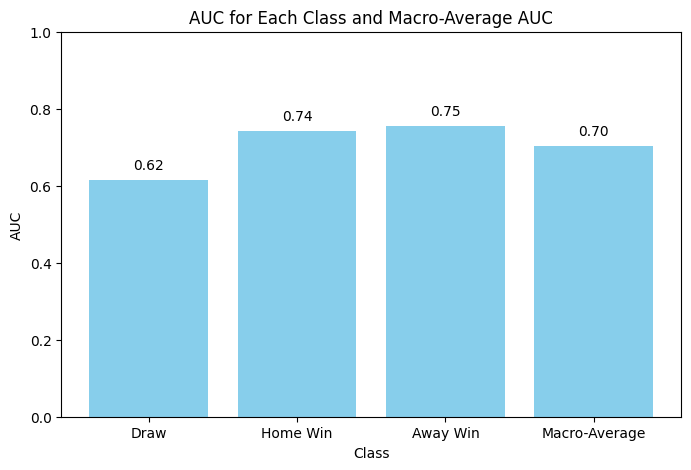

In [45]:
util.plot_auc_per_class(auc_per_class, class_names, auc_macro)

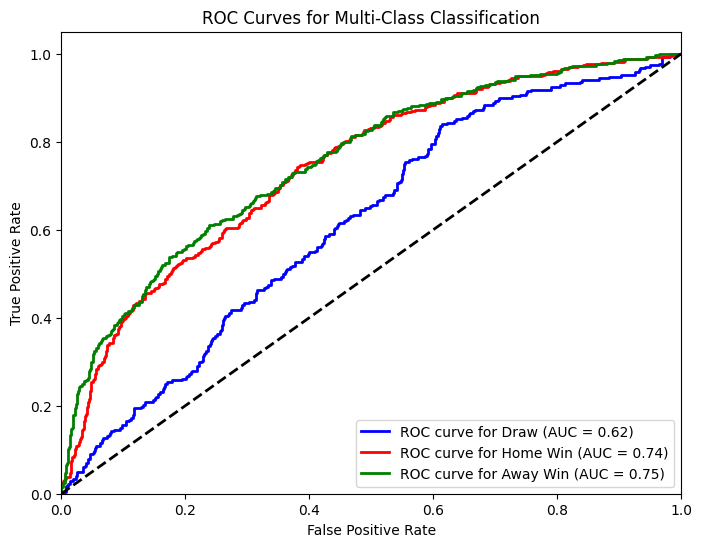

In [46]:
util.plot_multi_class_roc(
    y_test_remapped, y_pred_proba, classes=[0,1,2], class_names=["Draw", "Home Win", "Away Win"]
)